# PHY480/905 Semester Project 

#### PHY 480/905 Semester Project
### &#9989; Jonathan Kho

#### &#9989; Last Updated on WHAT DATE

# Modeling advection in 1D


##  Introduction 

For my final project for PHY 480, I'm seeking to better understand and model advection in 1D. My interest in this project was piqued following some results from my independent research. I've been modeling a neutron star crust in 1D using the stellar evolution code dStar (which is very similar to MESA, and is written in fortran), and simulating a new type of thermonuclear explosion deep in the crust that was proposed last year. Following simulations of this explosion, I discovered that the entire outer crust of the star melts, which would lead to convective and advective processes. As I understand it, convection is very, very difficult to model numerically, so I'm seeking to understand how advection is done numerically, especially for the 1D case. 

Questions to answer:

- How is hydrodynamics modeled in code (at the basic level)
- What numerical approximations are used to approximate advection?
- How accurate are numerical hydrodynamic simulations at the 1D level?
- How do different compositions (molecular weight), temepratures affect fluid mechanics?
- What sets the convergence/stability for this code?

## Methodology

The basic premise behind modeling fluid mechanics (used here at least) is to discretize some differential equation that describes the advection process, generate a grid along an axis (a number line) with N cells that will store information about the fluid at that location, and then initialize some density distribution along the axis and iteratively update the cell's information according to the differential equation. 

The advection equation is as follows:
\begin{equation}
    \frac{\partial q(x,t)}{\partial t} + \frac{\partial q(x,t)v(x,t)}{\partial x} = s(x,t,q)
\end{equation}

where $q = \rho$ is some density (for example, mass density), and $s = 0$ for the advective equation for conservation of mass, and $q = \rho v$ and $s = -\frac{\partial p}{\partial x} + \rho f$ for the conservation equation of momentum. 

Explicitly, these equations are

\begin{equation}
    \frac{\partial \rho}{\partial t} + \frac{\partial \rho v}{\partial x} = 0
\end{equation}

\begin{equation}
    \frac{\partial \rho v}{\partial t} + \frac{\partial \rho v^2 + P}{\partial x} = \rho f
\end{equation}

where the pressure P is $P = \rho c_s^2$, and $c_s$ is the isothermal speed of sound: $c_s = \sqrt{\frac{k_B T}{\mu m_p}}$.

In order to numerically model these equations, we discretize them as follows:

\begin{equation}
    \frac{q_i^{n+1} - q_i^n}{t_n+1 - t_n} +v_0\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}} = 0 
\end{equation}

for the ith cell location and the nth time step.

This allows us to solve for $q_i^{n+1}$:

\begin{equation}
    q_i^{n+1} =  q_i^n - v_0(t_{n+1} - t_n)\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}}
\end{equation}

I began investigating the above questions by first investigating what code already has been written on this subject and what I can learn from the current literature. On the website cited in the cell below, I found the following snipet of code that demonstrated a naive implementation of an advective code:

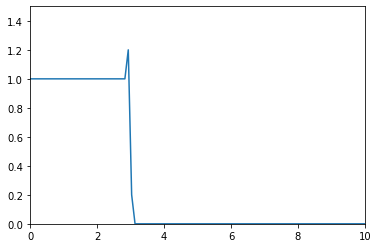

In [4]:
# Naive method
# Credit to: https://www.ita.uni-heidelberg.de/~dullemond/lectures/studtage_compastro_2018/index.shtml?lang=en

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

nx   = 100
nt   = 100
x    = np.linspace(0.,10.,nx)
t    = np.linspace(0.,10.,nt)
q    = np.zeros((nt,nx))
q[0,x<3] = 1.0     # Step function initial condition
v0   = 0.4         # Constant fluid velocity

for n in range(0,nt-1):
    dt          = t[n+1] - t[n]
    q[n+1,1:-1] = q[n,1:-1] - dt * v0 * ( q[n,2:] - q[n,:-2] ) / ( x[2:] - x[:-2] )
    q[n+1,0]    = q[n,0]
    q[n+1,-1]   = q[n,-1]

n = 0
def animupdate(frameNum, a0):
    global n,q,x,nt
    y = q[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [])
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('naiveadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

As can be seen above, this naive method results in exponentially increasing oscillations in the density that are very unphysical. This comes about because when we use the discretization above, we want to update our ith cell differently if mass is flowing into it from the left or the right; that is, if our fluid velocity $v_0$ is positive or negative. One solution to this problem is to simply create two cases where you change your updated value for the ith cell depending on whether mass is flowing from the i-1 cell or the i+1 cell. This is called the "upwind" method becuase we are updating our cells "upwind" - in the direction of fluid moton. 

To do this, I began by creating my own grid class that would store values for each spatial cell and each time step, and that could be used in my advection function. I then wrote an upwind advection function to solve for the fluid's density distribution as a function of time:

In [10]:
# Creating a basic grid:

class grid():
    
    def __init__(self,xsize,tmax):
        
        self.vals = np.zeros((tmax,xsize))
        
    def initialize(self,vals):
    
        self.vals[0,:] = vals
    
    def get_vals(self):
        
        return(self.vals)
    
    def update(self,loc,new_vals):
        
        self.vals[loc] = new_vals
        
        
# Creating my simple advection function using the upwind method:

def solve_adv(vals, C = 0.1,v0 = 1,tfactor = 1):
    
    xsize = len(vals)
    dx = (1/xsize) # Taking even step sizes dx
    dt = C*dx/v0 # Calculating our dt steps from our C value, see explanation below!
    tmax = tfactor*xsize/v0
    tlength = int(tmax/dt)
    
    board = grid(xsize,tlength)
    board.initialize(abs(vals)) # Ensuring all positive values
        
    for t in range(tlength-1):
        
        vals = board.get_vals()
        
        for i in range(xsize):
            
            if v0 > 0: # Our updated values will change depending on which way our fluid is flowing
                # The modulus here is to be careful not to index past the size of our board:
                updated_val = vals[t,i] - C * ( vals[t,i] - vals[t,(i-1)] ) 
                board.update((t+1,i),updated_val) 
                
            elif v0 < 0:
                # If our fluid is flowing backwards, we want to check the difference with our i-1 cell
                updated_val = vals[t,i] - C * ( vals[t,i] - vals[t,(i+1)%xsize] )
                board.update((t+1,i),updated_val) 

    return(board)

Let's see how our code does! We create an initial sinusoidal density distribution, which may not be very physical but will certainly look interesting and will tell us whether our code is working as expected.

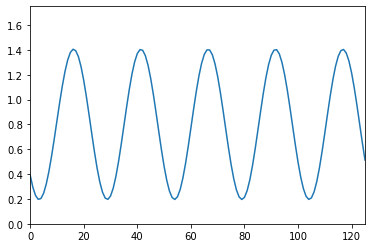

In [11]:
x = np.arange(0,2*np.pi,0.05)
y = 0.8 + 0.8*np.sin(5*x)

board = solve_adv(y,v0 = 10,tfactor = 1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

def animupdate(frameNum, a0):
    global n,vals,x,nt
    y = vals[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
# anim.save('forwardadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

Our code works! As we can see above, the fluid collectively moves at a certain velocity $v_0$, and while it moves, the peaks and troughs begin to smoothen out as the fluid advects. We can see that this function also works for negative velocities:


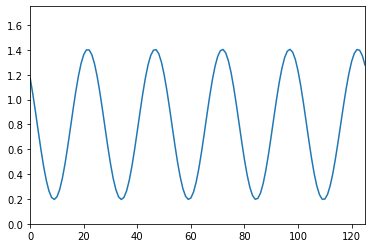

In [12]:
board = solve_adv(y,v0 = -10,tfactor = 1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

def animupdate(frameNum, a0):
    global n,vals,x,nt
    y = vals[n,:]
    a0.set_data(x, y)
    n = (n + 1) % nt
    # return a0,

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.75))
a0, = ax.plot([], [])
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
# anim.save('forwardadvection.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

So why does our density profile smooth out? We can find the answer easily examining our discretized equation:

\begin{equation}
    q_i^{n+1} =  q_i^n - v_0(t_{n+1} - t_n)\frac{q_{i+1}^n - q_{i-1}^n}{x_{i+1} - x_{i-1}}
\end{equation}

For the upwind method, the above becomes two cases:

For $v_0 > 0$:

\begin{equation}
    q_i^{n+1} =  q_i^n - |v_0|(t_{n+1} - t_n)\frac{q_{i}^n - q_{i-1}^n}{x_{i+1} - x_{i}}
\end{equation}

For $v_0 < 0$:

\begin{equation}
    q_i^{n+1} =  q_i^n - |v_0|(t_{n+1} - t_n)\frac{q_{i}^n - q_{i+1}^n}{x_{i+1} - x_{i}}
\end{equation}

Here, the indices of the x's aren't too important for me, as each $\Delta x$ is the same as long as we are looking at the difference from i to i + 1. The difference in the two equations is subtle, but important. For positive velocities, we want to know whether the i-1 cell has more mass in it than the ith cell. If it does, (i.e. if $q_{i}^n - q_{i-1}^n < 0$) then our ith cell will gain mass, since our fluid is moving in the +i direction. The opposite is also true: if there is more mass in the ith cell than the i-1 cell, the difference $q_{i}^n - q_{i-1}^n$ will be positive, and our updated value for $q_i^{n+1}$ will be smaller than $q_i^{n}$. The same reasoning can be applied to negative velocities, and our equation above has been changed to reflect this. 

Now, I've been a little sneaky in how I developed my advection code, and this was on purpose. In the above function, I didn't write out the discretized equations exactly. Instead, I used a parameter C to serve as the factor that determined how big of a step the code takes, where $C = v_0\frac{dt}{dx}$. This is a dimensionless variable, and is used to ensure that we don't lose information when we are iterating. The reason this is important is because if our fluid is moving at some velocity $v_0$ that is faster than how quickly we are iterating across our cells ($\frac{dt}{dx}$), then we want to reduce our time step dt so we don't have mass moving from the i-2 cell into the ith cell (our algorithm assumes this isn't happening, and that mass transfer only occurs between adjacent cells). 

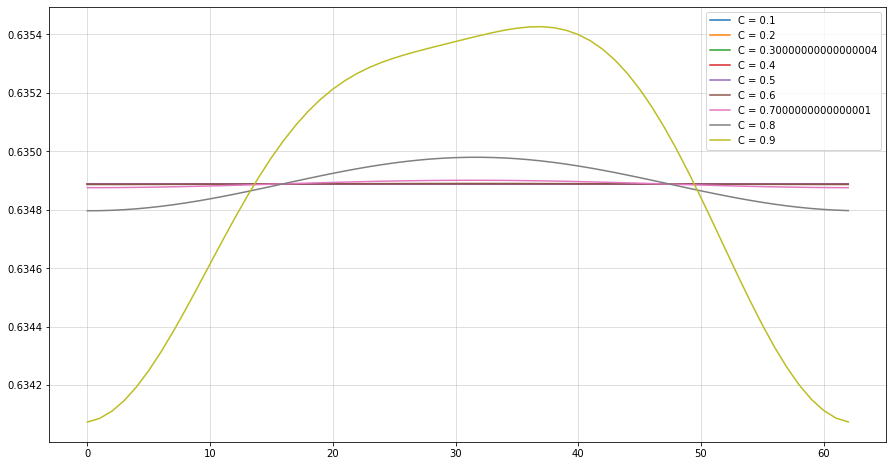

In [7]:
# Testing C parameter for stability:

x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)

Cs = np.arange(0.1,1,0.1)

solns = []

for i in range(len(Cs)):
    soln = solve_adv(vals = y,C = Cs[i])
    solns.append(soln.get_vals()[-1,:])
    
x = np.arange(len(solns[0]))
plt.figure(figsize = (15,8))
for i in range(len(solns)):
    plt.plot(x,solns[i],label = 'C = {}'.format(Cs[i]))
    
plt.legend()
plt.grid(alpha = 0.5)
plt.savefig('C_variations_upwind')

In [13]:
# Implementing pressure and different molecular weight

def advanced_adv(vals, C = 0.1,v0 = 100,tfactor = 1,mu = 1): 
    
    xsize = len(vals)
    dx = (1/xsize) # Taking even step sizes dx
    dt = C*dx/v0 # Calculating our dt steps from our C value
    tmax = tfactor*xsize/v0
    tlength = int(tmax/dt)
    
    # kB = 1.38e-23 # Boltzmann's constant
    # mp = 1.67e-27 # Proton mass
    # cs2 = kB*T/(mu*mp) Actual sound crossing speed, but only interested in mu scalings
    cs2 = 1/mu # Sound-crossing speed squared, relevant for pressure term
    
    board = grid(xsize,tlength)
    board.initialize(abs(vals)) # Ensuring all positive values
        
    for t in range(tlength-1):
        
        vals = board.get_vals()
            
        for i in range(xsize):
            
            if v0 > 0: # Our updated values will change depending on which way our fluid is flowing
                # The modulus here is to be careful not to index past the size of our board:
                updated_val = vals[t,i] - C * (cs2 + v0**2)/v0**2 * ( vals[t,i] - vals[t,(i-1)] ) 
                board.update((t+1,i),updated_val) 
                
            elif v0 < 0:
                # If our fluid is flowing backwards, we want to check the difference with our i-1 cell
                updated_val = vals[t,i] - C * (cs2 + v0**2)/v0**2 * ( vals[t,i] - vals[t,(i+1)%xsize] )
                board.update((t+1,i),updated_val)

    return(board)

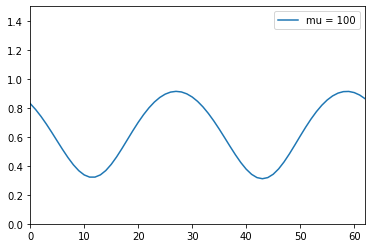

In [14]:
x = np.arange(0,2*np.pi,0.1)
y = np.sin(x)
mu1 = 100

board = advanced_adv(y,v0 = 10,mu = mu1)

vals = board.get_vals()

n = 0
nt = len(vals)
x = np.arange(len(vals[0]))

fig = plt.figure()
ax  = plt.axes(xlim=(x.min(),x.max()),ylim=(0.,1.5))
a0, = ax.plot([], [],label = 'mu = {}'.format(mu1))
plt.legend()
anim = animation.FuncAnimation(fig,animupdate,fargs=(a0,),interval=40)
anim.save('muadvection5.mp4', writer = 'ffmpeg', fps = 30)

HTML(anim.to_html5_video())

## Results and Discussion

_(What did you find when you carried out your methods? Some of your code related to presenting results/figures/data may be replicated from the methods section or may only be present in
this section.
All of the plots that you plan on using for your presentation should be present in this section)_

##  Conclusion and Perspectives

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   
Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. 
**Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

1. https://www.ita.uni-heidelberg.de/~dullemond/lectures/studtage_compastro_2018/index.shtml?lang=en
2. https://github.com/python-hydro/hydro_examples
3. http://bender.astro.sunysb.edu/hydro_by_example/CompHydroTutorial.pdf

##  Appendices
